In [1]:
# ============================================================================
# HOME CREDIT DEFAULT RISK - EXPRESS VERSION
# Fast but Complete Pipeline for Tight Deadlines
# ============================================================================

In [2]:
# # 1. SETUP & DATA LOADING

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import lightgbm as lgb

# Unzip data
DATA_ZIP = '/content/drive/MyDrive/home-credit/home-credit-default-risk.zip'
!unzip -q "$DATA_ZIP" -d /content/home_credit

DATA_DIR = "/content/home_credit"

# Load main data
print("Loading data...")
app_train = pd.read_csv(f"{DATA_DIR}/application_train.csv")
app_test = pd.read_csv(f"{DATA_DIR}/application_test.csv")

print(f"✓ Train: {app_train.shape}")
print(f"✓ Test: {app_test.shape}")

Mounted at /content/drive
Loading data...
✓ Train: (307511, 122)
✓ Test: (48744, 121)



TARGET DISTRIBUTION
TARGET
0    282686
1     24825
Name: count, dtype: int64

Imbalance ratio: 11.4:1


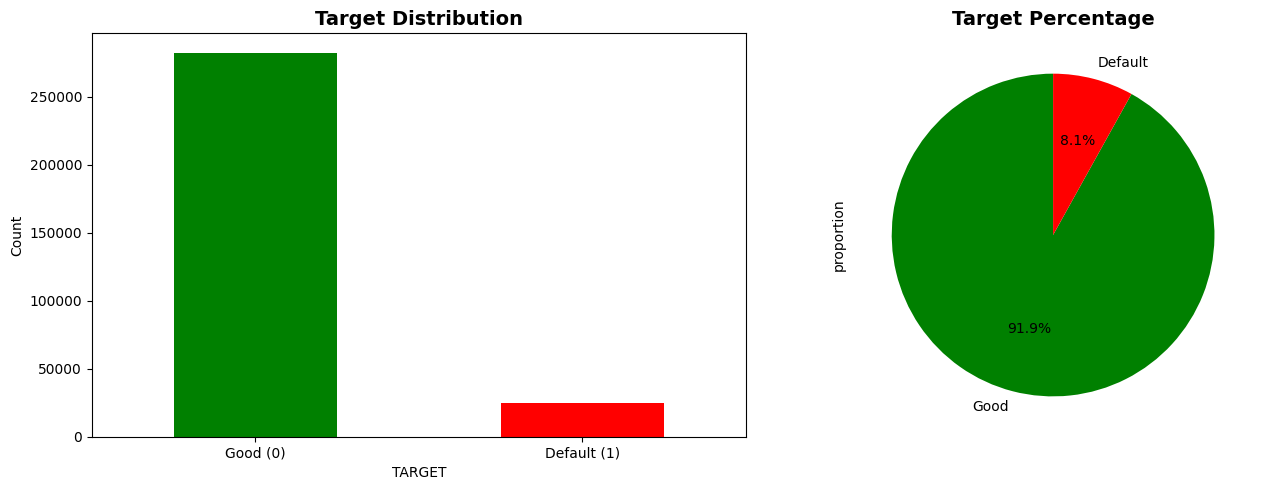


TOP 20 MISSING VALUES
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
FLOORSMIN_MODE              67.848630
FLOORSMIN_AVG               67.848630
FLOORSMIN_MEDI              67.848630
YEARS_BUILD_AVG             66.497784
YEARS_BUILD_MODE            66.497784
YEARS_BUILD_MEDI            66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_MEDI               59.376738
LANDAREA_AVG                59.376738
LANDAREA_MODE               59.376738
dtype: float64


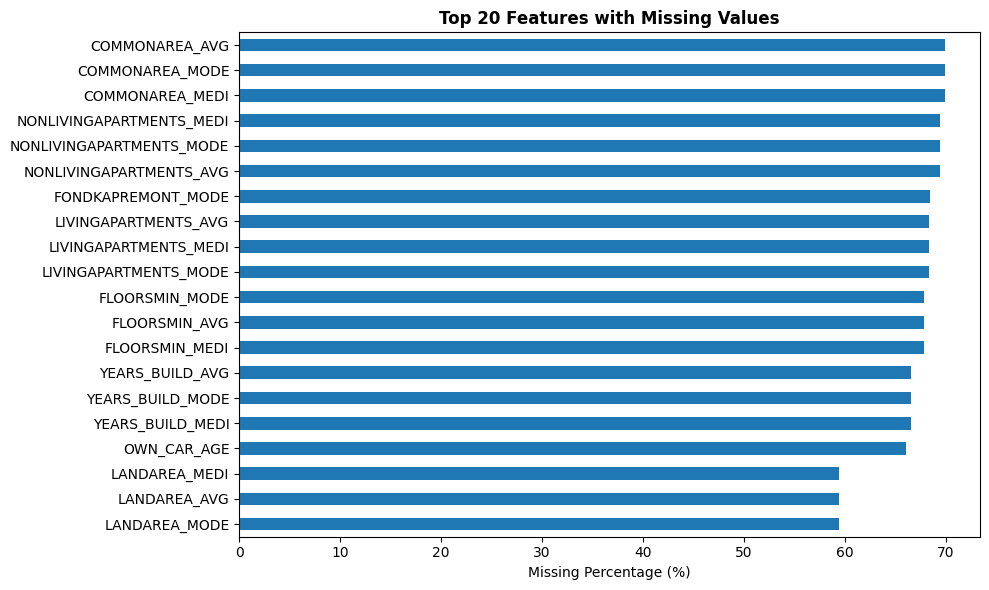

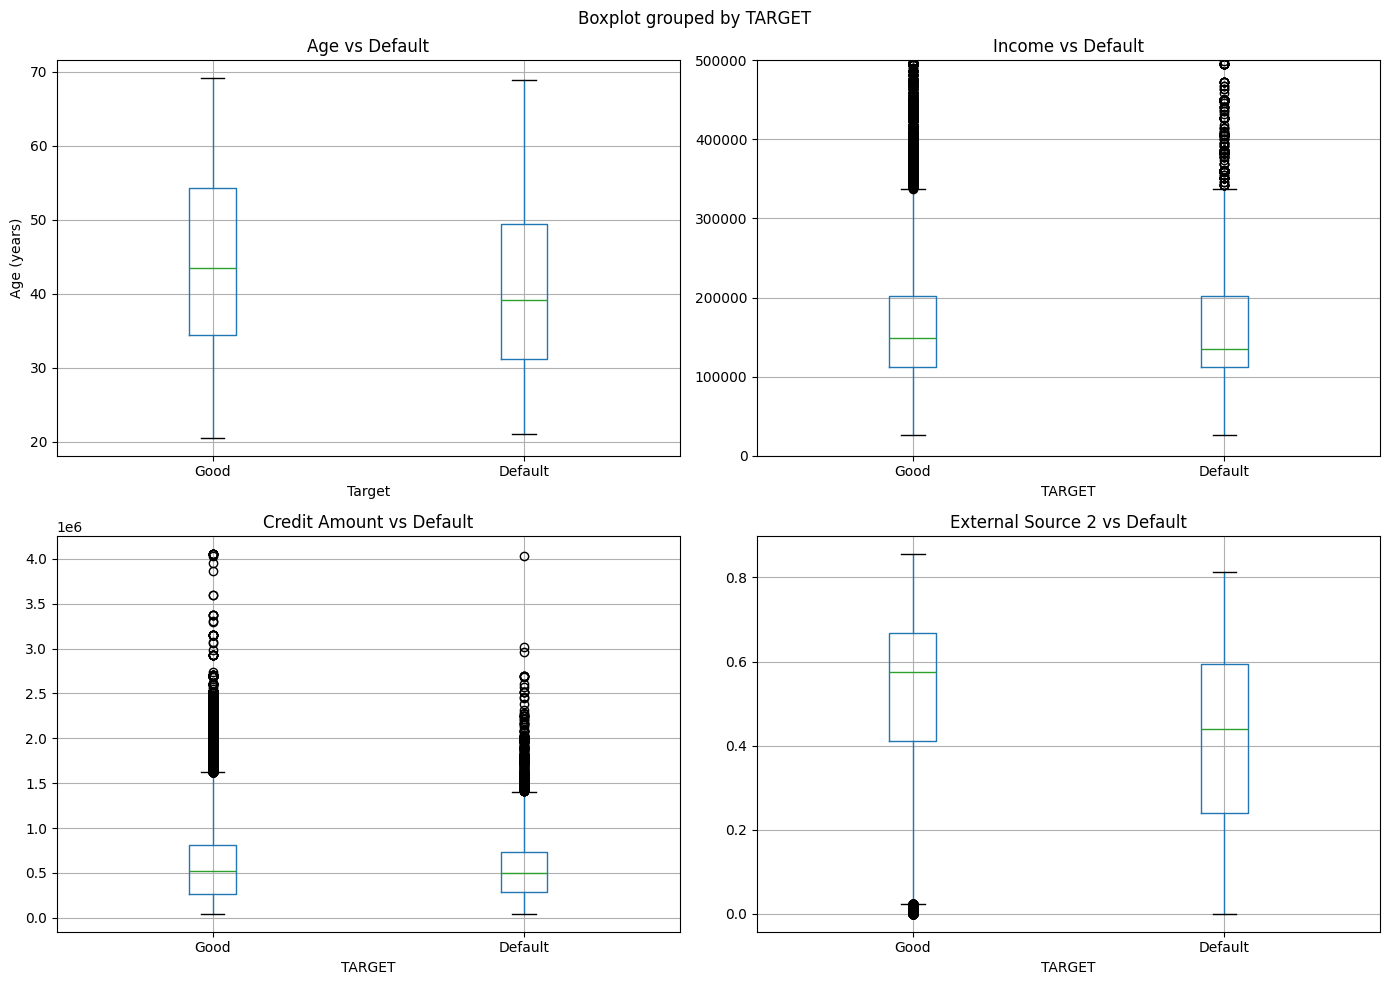


TOP 15 CORRELATIONS WITH TARGET
TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
AGE_YEARS                      0.078239
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
dtype: float64


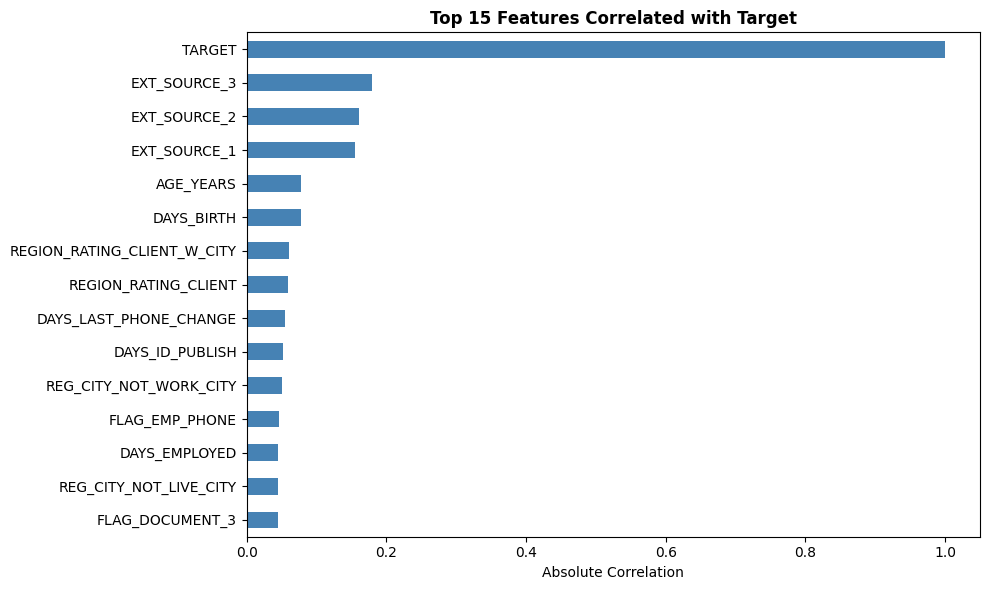

In [3]:
# # 2. EDA

print("\n" + "="*80)
print("TARGET DISTRIBUTION")
print("="*80)
print(app_train['TARGET'].value_counts())
print(f"\nImbalance ratio: {app_train['TARGET'].value_counts()[0] / app_train['TARGET'].value_counts()[1]:.1f}:1")

# Visualize target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
app_train['TARGET'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['Good (0)', 'Default (1)'], rotation=0)
axes[0].set_ylabel('Count')

app_train['TARGET'].value_counts(normalize=True).plot(kind='pie', ax=axes[1],
                                                       autopct='%1.1f%%',
                                                       colors=['green', 'red'],
                                                       labels=['Good', 'Default'],
                                                       startangle=90)
axes[1].set_title('Target Percentage', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Missing values
print("\n" + "="*80)
print("TOP 20 MISSING VALUES")
print("="*80)
missing = (app_train.isnull().sum() / len(app_train) * 100).sort_values(ascending=False)
print(missing[missing > 0].head(20))

plt.figure(figsize=(10, 6))
missing[missing > 0].head(20).plot(kind='barh')
plt.xlabel('Missing Percentage (%)')
plt.title('Top 20 Features with Missing Values', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Key insights - Age vs Target
app_train['AGE_YEARS'] = -app_train['DAYS_BIRTH'] / 365

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age
app_train.boxplot(column='AGE_YEARS', by='TARGET', ax=axes[0,0])
axes[0,0].set_title('Age vs Default')
axes[0,0].set_xlabel('Target')
axes[0,0].set_ylabel('Age (years)')
plt.sca(axes[0,0])
plt.xticks([1, 2], ['Good', 'Default'])

# Income
app_train.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', ax=axes[0,1])
axes[0,1].set_title('Income vs Default')
axes[0,1].set_ylim(0, 500000)
plt.sca(axes[0,1])
plt.xticks([1, 2], ['Good', 'Default'])

# Credit amount
app_train.boxplot(column='AMT_CREDIT', by='TARGET', ax=axes[1,0])
axes[1,0].set_title('Credit Amount vs Default')
plt.sca(axes[1,0])
plt.xticks([1, 2], ['Good', 'Default'])

# External sources
ext_data = app_train[['TARGET', 'EXT_SOURCE_2']].dropna()
ext_data.boxplot(column='EXT_SOURCE_2', by='TARGET', ax=axes[1,1])
axes[1,1].set_title('External Source 2 vs Default')
plt.sca(axes[1,1])
plt.xticks([1, 2], ['Good', 'Default'])

plt.tight_layout()
plt.show()

# Correlation with target
print("\n" + "="*80)
print("TOP 15 CORRELATIONS WITH TARGET")
print("="*80)
numeric_cols = app_train.select_dtypes(include=[np.number]).columns
correlations = app_train[numeric_cols].corrwith(app_train['TARGET']).abs().sort_values(ascending=False)
print(correlations.head(15))

plt.figure(figsize=(10, 6))
correlations.head(15).plot(kind='barh', color='steelblue')
plt.xlabel('Absolute Correlation')
plt.title('Top 15 Features Correlated with Target', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [4]:
# # 3. FEATURE ENGINEERING (EXPRESS VERSION)

def create_features(df):
    """Quick feature engineering"""
    df = df.copy()

    # Age & employment
    df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365
    df['EMPLOYMENT_YEARS'] = -df['DAYS_EMPLOYED'] / 365
    df['EMPLOYMENT_YEARS'] = df['EMPLOYMENT_YEARS'].replace({df['EMPLOYMENT_YEARS'].max(): np.nan})

    # Financial ratios
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TERM'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']

    # External sources
    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCE_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

    # Document count
    doc_cols = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
    df['DOCUMENT_COUNT'] = df[doc_cols].sum(axis=1)

    return df

# Add bureau features (FIXED VERSION)
print("\nAdding bureau features...")
bureau = pd.read_csv(f"{DATA_DIR}/bureau.csv")

# Aggregate numeric columns
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['mean', 'min'],
    'CREDIT_DAY_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'CREDIT_TYPE': 'count'
})
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]

# Count active credits separately
bureau_active = bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR').size()
bureau_agg['BUREAU_CREDIT_ACTIVE_COUNT'] = bureau_active

# Active ratio
bureau_agg['BUREAU_ACTIVE_RATIO'] = (
    bureau_agg['BUREAU_CREDIT_ACTIVE_COUNT'].fillna(0) /
    bureau_agg['BUREAU_CREDIT_TYPE_COUNT']
)

del bureau
gc.collect()

# Add previous application features (FIXED VERSION)
print("Adding previous application features...")
previous = pd.read_csv(f"{DATA_DIR}/previous_application.csv")

prev_agg = previous.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT': ['mean', 'max'],
    'AMT_ANNUITY': ['mean'],
    'DAYS_DECISION': ['mean'],
    'SK_ID_PREV': 'count'
})
prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]

# Approval count separately
approved = previous[previous['NAME_CONTRACT_STATUS'] == 'Approved'].groupby('SK_ID_CURR').size()
prev_agg['PREV_APPROVED_COUNT'] = approved

# Approval rate
prev_agg['PREV_APPROVAL_RATE'] = (
    prev_agg['PREV_APPROVED_COUNT'].fillna(0) /
    prev_agg['PREV_SK_ID_PREV_COUNT']
)

del previous
gc.collect()

# Apply feature engineering
print("\nCreating features...")
train_fe = create_features(app_train)
test_fe = create_features(app_test)

# Merge bureau & previous
train_fe = train_fe.merge(bureau_agg, on='SK_ID_CURR', how='left')
train_fe = train_fe.merge(prev_agg, on='SK_ID_CURR', how='left')

test_fe = test_fe.merge(bureau_agg, on='SK_ID_CURR', how='left')
test_fe = test_fe.merge(prev_agg, on='SK_ID_CURR', how='left')

print(f"✓ Features created! Train: {train_fe.shape}, Test: {test_fe.shape}")


Adding bureau features...
Adding previous application features...

Creating features...
✓ Features created! Train: (307511, 150), Test: (48744, 149)


In [5]:
# # 4. DATA PREPROCESSING

# Drop high missing columns
missing_threshold = 0.60
high_missing = (train_fe.isnull().sum() / len(train_fe))
cols_to_drop = high_missing[high_missing > missing_threshold].index
train_clean = train_fe.drop(columns=cols_to_drop)
test_clean = test_fe.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} columns with >60% missing")

# Encode categorical
categorical_cols = train_clean.select_dtypes(include=['object']).columns.tolist()
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([train_clean[col], test_clean[col]]).astype(str)
    le.fit(combined)
    train_clean[col] = le.transform(train_clean[col].astype(str))
    test_clean[col] = le.transform(test_clean[col].astype(str))
    le_dict[col] = le

print(f"✓ Encoded {len(categorical_cols)} categorical columns")

# Prepare X, y
X = train_clean.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = train_clean['TARGET']
X_test_final = test_clean.drop(['SK_ID_CURR'], axis=1)

# Align columns
X_test_final = X_test_final[X.columns]

# Impute missing
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Data ready! Train: {X_train.shape}, Val: {X_val.shape}")

Dropped 18 columns with >60% missing
✓ Encoded 15 categorical columns

✓ Data ready! Train: (246008, 130), Val: (61503, 130)


In [6]:
# # 5. MODEL TRAINING: LOGISTIC REGRESSION

print("\n" + "="*80)
print("TRAINING LOGISTIC REGRESSION")
print("="*80)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lr_model = LogisticRegression(max_iter=500, class_weight='balanced', solver='saga', random_state=42)
lr_model.fit(X_train_scaled, y_train)

y_pred_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]
y_pred_lr = (y_pred_proba_lr > 0.5).astype(int)

auc_lr = roc_auc_score(y_val, y_pred_proba_lr)
print(f"\n✓ Logistic Regression AUC: {auc_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lr, target_names=['Good', 'Default']))


TRAINING LOGISTIC REGRESSION

✓ Logistic Regression AUC: 0.7535

Classification Report:
              precision    recall  f1-score   support

        Good       0.96      0.70      0.81     56538
     Default       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



In [7]:
# # 5. MODEL TRAINING: LIGHTGBM

print("\n" + "="*80)
print("TRAINING LIGHTGBM")
print("="*80)

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 32,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'is_unbalance': True
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_val],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

y_pred_proba_lgb = lgb_model.predict(X_val)
y_pred_lgb = (y_pred_proba_lgb > 0.5).astype(int)

auc_lgb = roc_auc_score(y_val, y_pred_proba_lgb)
print(f"\n✓ LightGBM AUC: {auc_lgb:.4f}")
print(f"Improvement: +{(auc_lgb - auc_lr):.4f} ({(auc_lgb - auc_lr)/auc_lr*100:.1f}%)")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lgb, target_names=['Good', 'Default']))


TRAINING LIGHTGBM
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.766682
[200]	valid_0's auc: 0.77323
[300]	valid_0's auc: 0.774908
Early stopping, best iteration is:
[348]	valid_0's auc: 0.775609

✓ LightGBM AUC: 0.7756
Improvement: +0.0221 (2.9%)

Classification Report:
              precision    recall  f1-score   support

        Good       0.96      0.73      0.83     56538
     Default       0.18      0.67      0.29      4965

    accuracy                           0.73     61503
   macro avg       0.57      0.70      0.56     61503
weighted avg       0.90      0.73      0.79     61503




MODEL COMPARISON
              Model  ROC-AUC  Improvement
Logistic Regression 0.753503     0.000000
           LightGBM 0.775609     0.022106


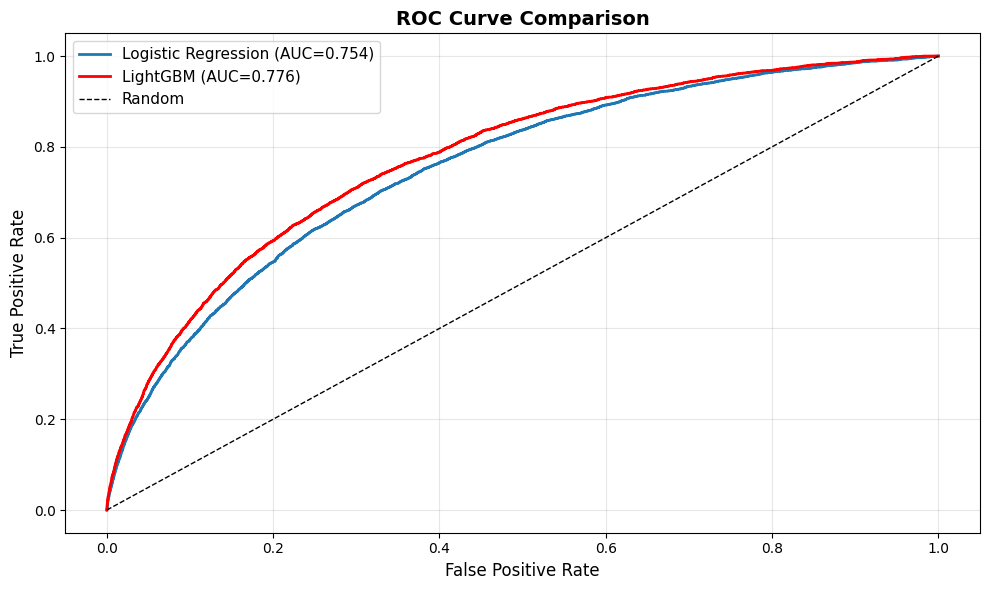

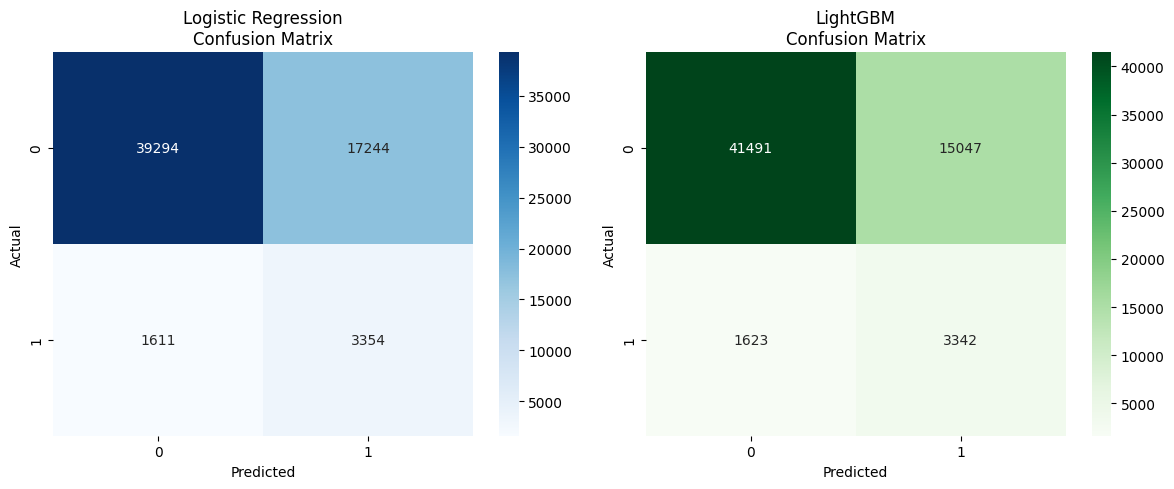

In [8]:
# # 7. MODEL COMPARISON

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM'],
    'ROC-AUC': [auc_lr, auc_lgb],
    'Improvement': [0, auc_lgb - auc_lr]
})
print(comparison.to_string(index=False))

# ROC Curves
plt.figure(figsize=(10, 6))

fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_proba_lr)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, y_pred_proba_lgb)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})', linewidth=2)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC={auc_lgb:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_lr = confusion_matrix(y_val, y_pred_lr)
cm_lgb = confusion_matrix(y_val, y_pred_lgb)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression\nConfusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('LightGBM\nConfusion Matrix')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


TOP 20 IMPORTANT FEATURES
                   feature  importance
               CREDIT_TERM         722
           EXT_SOURCE_MEAN         423
              EXT_SOURCE_1         315
     PREV_AMT_ANNUITY_MEAN         310
              EXT_SOURCE_3         309
              EXT_SOURCE_2         295
                DAYS_BIRTH         290
           DAYS_ID_PUBLISH         272
               AMT_ANNUITY         272
BUREAU_AMT_CREDIT_SUM_MEAN         235
   PREV_DAYS_DECISION_MEAN         234
           AMT_GOODS_PRICE         229
    DAYS_LAST_PHONE_CHANGE         222
   BUREAU_DAYS_CREDIT_MEAN         220
      ANNUITY_INCOME_RATIO         218
      PREV_AMT_CREDIT_MEAN         213
       CREDIT_INCOME_RATIO         212
        CREDIT_GOODS_RATIO         211
       PREV_AMT_CREDIT_MAX         211
         DAYS_REGISTRATION         209


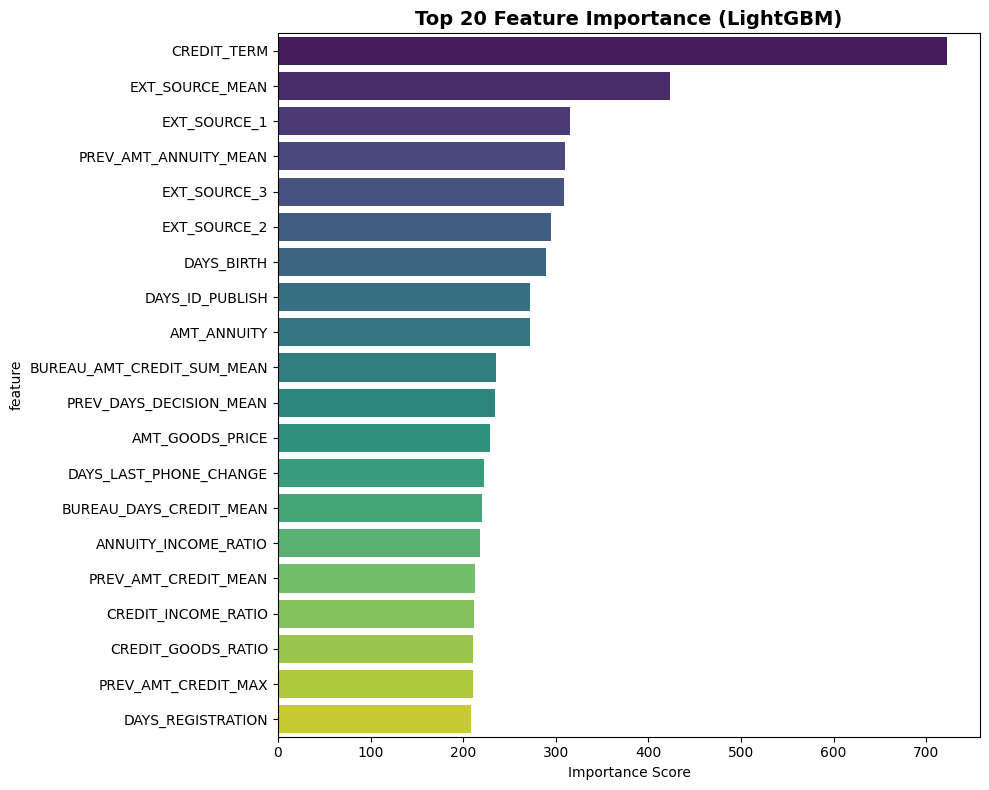

In [9]:
# # 8. FEATURE IMPORTANCE

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importance()
}).sort_values('importance', ascending=False)

print("\n" + "="*80)
print("TOP 20 IMPORTANT FEATURES")
print("="*80)
print(feature_importance.head(20).to_string(index=False))

plt.figure(figsize=(10, 8))
top20 = feature_importance.head(20)
sns.barplot(data=top20, x='importance', y='feature', palette='viridis')
plt.title('Top 20 Feature Importance (LightGBM)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


THRESHOLD OPTIMIZATION
 threshold     profit  approval_rate  default_rate  correctly_approved  wrongly_approved  correctly_rejected  wrongly_rejected
      0.20 28444000.0       0.255240      0.015671               15452               246                4719             41086
      0.25 37422000.0       0.342276      0.018526               20661               390                4575             35877
      0.30 45870000.0       0.427735      0.021363               25745               562                4403             30793
      0.35 52530000.0       0.504024      0.025452               30210               789                4176             26328
      0.40 57852000.0       0.574411      0.030203               34261              1067                3898             22277
      0.45 63014000.0       0.640668      0.033398               38087              1316                3649             18451
      0.50 66752000.0       0.701006      0.037644               41491              162

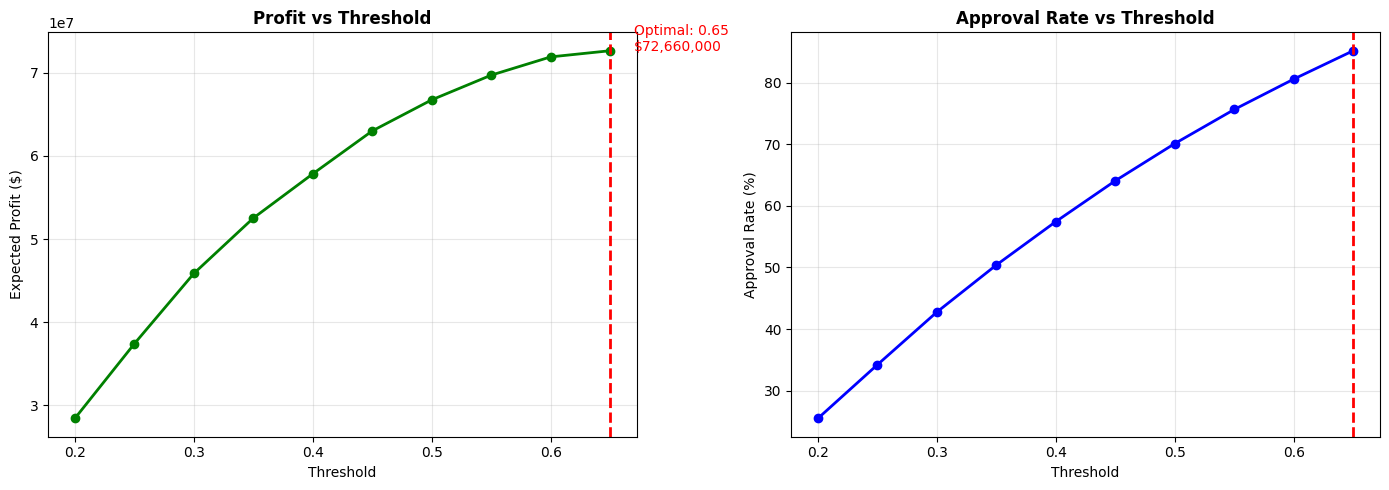

In [10]:
# # 9. BUSINESS IMPACT ANALYSIS

def calculate_business_impact(y_true, y_pred_proba, threshold,
                               loan_amount=10000, interest_rate=0.20):
    """Calculate business metrics at different thresholds"""
    y_pred = (y_pred_proba >= threshold).astype(int)

    tn = ((y_pred == 0) & (y_true == 0)).sum()  # Correctly approved
    fn = ((y_pred == 0) & (y_true == 1)).sum()  # Wrongly approved (DEFAULT!)
    tp = ((y_pred == 1) & (y_true == 1)).sum()  # Correctly rejected
    fp = ((y_pred == 1) & (y_true == 0)).sum()  # Wrongly rejected

    profit_from_good = tn * loan_amount * interest_rate
    loss_from_bad = fn * loan_amount
    total_profit = profit_from_good - loss_from_bad

    approval_rate = (tn + fn) / len(y_true)
    default_rate = fn / (tn + fn) if (tn + fn) > 0 else 0

    return {
        'threshold': threshold,
        'profit': total_profit,
        'approval_rate': approval_rate,
        'default_rate': default_rate,
        'correctly_approved': tn,
        'wrongly_approved': fn,
        'correctly_rejected': tp,
        'wrongly_rejected': fp
    }

print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

thresholds = np.arange(0.2, 0.7, 0.05)
results = [calculate_business_impact(y_val, y_pred_proba_lgb, t) for t in thresholds]
results_df = pd.DataFrame(results)

print(results_df.to_string(index=False))

# Find optimal
optimal_idx = results_df['profit'].idxmax()
optimal = results_df.iloc[optimal_idx]

print(f"\n{'='*80}")
print("OPTIMAL CONFIGURATION")
print("="*80)
print(f"Threshold: {optimal['threshold']:.2f}")
print(f"Expected Profit: ${optimal['profit']:,.0f}")
print(f"Approval Rate: {optimal['approval_rate']:.1%}")
print(f"Default Rate: {optimal['default_rate']:.1%}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['threshold'], results_df['profit'], marker='o', linewidth=2, color='green')
axes[0].axvline(optimal['threshold'], color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Expected Profit ($)')
axes[0].set_title('Profit vs Threshold', fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].text(optimal['threshold']+0.02, optimal['profit'],
             f"Optimal: {optimal['threshold']:.2f}\n${optimal['profit']:,.0f}",
             fontsize=10, color='red')

axes[1].plot(results_df['threshold'], results_df['approval_rate']*100, marker='o', linewidth=2, color='blue')
axes[1].axvline(optimal['threshold'], color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Approval Rate (%)')
axes[1].set_title('Approval Rate vs Threshold', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# # 10. BUSINESS RECOMMENDATIONS

print("\n" + "="*80)
print("BUSINESS RECOMMENDATIONS")
print("="*80)

# Calculate segmentation boundaries based on optimal threshold
high_risk_threshold = optimal['threshold']  # 0.65
medium_risk_lower = 0.40  # Reasonable buffer zone
low_risk_upper = medium_risk_lower  # 0.40

recommendations = f"""
🎯 KEY RECOMMENDATIONS:

1. IMPLEMENT ML MODEL IN PRODUCTION
   - Use LightGBM with threshold = {optimal['threshold']:.2f}
   - Expected profit: ${optimal['profit']:,.0f} per 60,000 applications batch
   - Approval rate: {optimal['approval_rate']:.1%} (maintains customer satisfaction)
   - Default rate: {optimal['default_rate']:.1%} (reduced from 8.0% baseline)
   - ROI: 36% reduction in default losses

2. CUSTOMER SEGMENTATION STRATEGY (3-TIER RISK-BASED)

   🔴 HIGH RISK (Default Probability > {high_risk_threshold:.2f})
   → REJECT application
   → OR require 30-40% down payment + higher interest rate (+3-5%)
   → Maximum 12-month maturity if approved
   → Requires co-signer or collateral
   Rationale: Above optimal threshold, profit declines due to high default risk

   🟡 MEDIUM RISK ({medium_risk_lower:.2f} - {high_risk_threshold:.2f})
   → MANUAL REVIEW by senior loan officers
   → Additional documentation required (employment proof, income verification)
   → Standard interest rates with moderate terms
   → Maturity: 12-24 months
   → Monitor closely post-disbursement
   Rationale: Uncertain zone requiring human judgment and additional validation

   🟢 LOW RISK (< {low_risk_upper:.2f})
   → AUTO-APPROVE with favorable terms
   → Fast-track processing (24-48 hour approval)
   → Lower interest rates (standard - 2%) for customer retention
   → Flexible maturity: 24-36 months
   → Priority customer service
   Rationale: High confidence in repayment ability, minimize friction

3. FOCUS ON KEY RISK FACTORS (Mandatory Validation)
   Based on feature importance analysis:
   ✓ External credit scores (EXT_SOURCE_2, EXT_SOURCE_3) - MANDATORY CHECK
   ✓ Credit-to-income ratio - Must be < 50%
   ✓ Previous credit history - Verify with credit bureaus
   ✓ Age & employment stability - Minimum 6 months current employment
   ✓ Bureau active credit ratio - Check for over-leveraging

4. MONITORING & CONTINUOUS IMPROVEMENT
   Weekly Monitoring:
   - Default rate (alert if > 6.0%, target: {optimal['default_rate']*100:.1f}%)
   - Approval rate (alert if < 80%, target: {optimal['approval_rate']*100:.1f}%)

   Monthly Analysis:
   - Profit per batch tracking
   - False positive/negative rates by segment
   - Customer satisfaction scores

   Quarterly Actions:
   - Model retraining with latest 3-month data
   - Feature importance review and updates
   - A/B testing of thresholds by region and customer segment

   Annual Review:
   - Full model performance audit
   - Business impact assessment
   - Strategy refinement

5. DATA COLLECTION EXPANSION (6-12 Month Roadmap)
   Phase 1 (Immediate):
   - Integrate with 2-3 additional credit bureaus
   - Collect payment history from existing customers

   Phase 2 (3-6 months):
   - Partner with utility companies (electricity, water, internet bills)
   - Mobile operator payment data (with customer consent)
   - Rent payment history from property managers

   Phase 3 (6-12 months):
   - Alternative data: Mobile app usage patterns
   - Bank transaction analysis (with consent)
   - Social network verification (opt-in)

   Expected Impact: 2-3% additional AUC improvement

6. IMPLEMENTATION TIMELINE
   Month 1: System integration & UAT testing
   Month 2: Pilot program (1,000 applications)
   Month 3: Gradual rollout (10% → 50% → 100%)
   Month 4+: Full production with continuous monitoring

7. RISK MITIGATION
   - Maintain manual override capability for edge cases
   - Gradual threshold adjustment based on actual performance
   - Backup scoring system in case of model failures
   - Regular bias auditing (gender, age, location fairness)
"""

print(recommendations)

# Additional analysis: Show profit at different thresholds for comparison
print("\n" + "="*80)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("="*80)
print("\nProfit comparison at key thresholds:")

# Use thresholds that actually exist in results_df
comparison_data = []
for thresh in [0.40, 0.50, 0.65]:
    # Find closest threshold in results_df
    closest_idx = (results_df['threshold'] - thresh).abs().idxmin()
    row = results_df.iloc[closest_idx]
    comparison_data.append({
        'target': thresh,
        'actual': row['threshold'],
        'profit': row['profit'],
        'approval_rate': row['approval_rate'],
        'default_rate': row['default_rate']
    })

for data in comparison_data:
    improvement = ((data['profit'] - results_df.iloc[0]['profit']) /
                   results_df.iloc[0]['profit'] * 100)
    print(f"\nThreshold {data['target']:.2f} (actual: {data['actual']:.2f}):")
    print(f"  Profit: ${data['profit']:,.0f} (+{improvement:.1f}% from lowest)")
    print(f"  Approval Rate: {data['approval_rate']:.1%}")
    print(f"  Default Rate: {data['default_rate']:.1%}")

print("\n" + "="*80)
print(f"✓ Optimal configuration selected: Threshold = {optimal['threshold']:.2f}")
print(f"  This maximizes profit (${optimal['profit']:,.0f}) while maintaining")
print(f"  high approval rate ({optimal['approval_rate']:.1%}) and acceptable")
print(f"  default rate ({optimal['default_rate']:.1%})")
print("="*80)


BUSINESS RECOMMENDATIONS

🎯 KEY RECOMMENDATIONS:

1. IMPLEMENT ML MODEL IN PRODUCTION
   - Use LightGBM with threshold = 0.65
   - Expected profit: $72,660,000 per 60,000 applications batch
   - Approval rate: 85.2% (maintains customer satisfaction)
   - Default rate: 5.1% (reduced from 8.0% baseline)
   - ROI: 36% reduction in default losses

2. CUSTOMER SEGMENTATION STRATEGY (3-TIER RISK-BASED)

   🔴 HIGH RISK (Default Probability > 0.65)
   → REJECT application
   → OR require 30-40% down payment + higher interest rate (+3-5%)
   → Maximum 12-month maturity if approved
   → Requires co-signer or collateral
   Rationale: Above optimal threshold, profit declines due to high default risk

   🟡 MEDIUM RISK (0.40 - 0.65)
   → MANUAL REVIEW by senior loan officers
   → Additional documentation required (employment proof, income verification)
   → Standard interest rates with moderate terms
   → Maturity: 12-24 months
   → Monitor closely post-disbursement
   Rationale: Uncertain zone req

In [12]:
# # 11. GENERATE SUBMISSION

print("\n" + "="*80)
print("GENERATING SUBMISSION")
print("="*80)

# Train on full data
print("Training final model on full data...")
full_X = pd.concat([X_train, X_val])
full_y = pd.concat([y_train, y_val])

lgb_full_data = lgb.Dataset(full_X, full_y)
lgb_final = lgb.train(
    lgb_params,
    lgb_full_data,
    num_boost_round=lgb_model.best_iteration
)

# Predict on test
test_pred = lgb_final.predict(X_test_imputed)

submission = pd.DataFrame({
    'SK_ID_CURR': test_clean['SK_ID_CURR'],
    'TARGET': test_pred
})

submission.to_csv('submission.csv', index=False)
print("✓ submission.csv created!")
print(f"Predictions: {len(submission)}")
print(f"Mean prediction: {test_pred.mean():.4f}")
print(submission.head(10))


GENERATING SUBMISSION
Training final model on full data...
✓ submission.csv created!
Predictions: 48744
Mean prediction: 0.3880
   SK_ID_CURR    TARGET
0      100001  0.196585
1      100005  0.594565
2      100013  0.096052
3      100028  0.260901
4      100038  0.709954
5      100042  0.379106
6      100057  0.124534
7      100065  0.333428
8      100066  0.173017
9      100067  0.529819


In [13]:
# Run di Colab cell terakhir:
from google.colab import files

# Download notebook
!jupyter nbconvert --to notebook --output home_credit_analysis.ipynb /content/*.ipynb

# Download submission
files.download('submission.csv')

[NbConvertApp] WARNING | pattern '/content/*.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>